# Part 1: Data Collection

## Part 1.1: Define functions to make API call, retrieve, parse, and save information

In [66]:
import requests
import json
import pandas as pd
import numpy as np
from tinydb import TinyDB, Query, where #install tinydb https://anaconda.org/conda-forge/tinydb
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

### Function article_get() prompts user with query words and makes API calls. For each given query word, ten pages of results containing metadata on related articles are returned. Article metadata as well as the search word (topic) are saved in a local database using TinyDB. The handle pointing to the TinyDB local file is returned.

In [3]:
def article_get():
    api_key = '&api-key=hRXjGGesi2cxGg7fcPDkuiAMRMGmcee2'
    topic = input('Choose a topic from China, Russia, Trump, Brexit, Immigration, Opioid : ')
    article_metadata = TinyDB('nyt_metadata.json')
    for page in range(10):
        url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?q='+topic+'&page='+str(page)+api_key
        response = requests.get(url)
        docs = response.json()['response']['docs']
        for doc in docs:
            doc['topic'] = topic
            article_metadata.insert(doc)
    return article_metadata

### Function article_parse() takes the url of an article as an argument and uses BeautifulSoup to parse and clean article body by adding text content between p tags. Cleaned article is returned.

In [37]:
def article_parse(article_url):
    response_article = requests.get(article_url)
    soup = BeautifulSoup(response_article.text, 'html.parser')
    p_tags = soup.find_all(class_= 'css-1ygdjhk evys1bk0')
    article = ''
    for p_tag in p_tags:
        p_text = p_tag.get_text()
        article = article + ' ' + p_text
        article = article.lstrip()
    return article

### Function article_deposit() uses article_metadata (a handle pointing to the local TinyDB database) as an argument, calls article_parse() to parse article if document type is article and store in local database, keywords are extracted from json array as string.

In [5]:
def article_deposit(article_metadata):
    article_db = TinyDB('nyt_article.json')
    for item in article_metadata:
        if item['document_type'] == 'article':
            keywords = ''
            for i in range(len(item['keywords'])):
                keywords = keywords + ', ' + item['keywords'][i]['value']
            keywords = keywords.lstrip(', ')
            article = article_parse(item['web_url'])
            article_db.insert({'id':item['_id'], 'title':item['headline']['main'], 'topic':item['topic'], 'keywords':keywords, 'word_count':item['word_count'],'article':article})
        else: continue
    return article_db

## Part 1.2: Make API calls and save metadata to local database

Get article metadata using topic: China (line is commented as it only needs to be run once).

In [6]:
#article_metadata = article_get()

Choose a topic from China, Russia, Trump, Brexit, Immigration, Opioid : China


Get article metadata using topic: Russia (line is commented as it only needs to be run once).

In [23]:
#article_metadata = article_get()

Choose a topic from China, Russia, Trump, Brexit, Immigration, Opioid : Russia


Get article metadata using topic: Trump (line is commented as it only needs to be run once).

In [26]:
#article_metadata = article_get()

Choose a topic from China, Russia, Trump, Brexit, Immigration, Opioid : Trump


Get article metadata using topic: Brexit (line is commented as it only needs to be run once).

In [29]:
#article_metadata = article_get()

Choose a topic from China, Russia, Trump, Brexit, Immigration, Opioid : Brexit


Get article metadata using topic: Immigration (line is commented as it only needs to be run once).

In [31]:
#article_metadata = article_get()

Choose a topic from China, Russia, Trump, Brexit, Immigration, Opioid : Immigration


Get article metadata using topic: Opioid (line is commented as it only needs to be run once).

In [35]:
#article_metadata = article_get()

Choose a topic from China, Russia, Trump, Brexit, Immigration, Opioid : Opioid


Check number of entries in the article metadata

In [9]:
len(article_metadata)

600

Check the titles for the a few entries in article metadata, the titles chosen represent the last article under each topic

In [9]:
for i in [99, 199, 299, 399, 499, 599]:
    print(article_metadata.all()[i]['headline']['main'])

Germany’s China Problem
Germany, France Condemn Russian Citizenship Decree for Ukraine
Trump Tower Meeting Emails 'Really Bad,' Aide Told Trump
ECB Ups Supervision Fees by 21 Percent Due to Brexit Costs
Immigration Arrests and Deportations Are Rising, I.C.E. Data Show
America’s 150-Year Opioid Epidemic


## Part 1.3: Read metadata, parse article, and save selected fields to local database

Establish connection to local databases

In [4]:
article_metadata = TinyDB('nyt_metadata.json')

Use article_metadata as an argument, call the article_deposite() function to parse article and store article body as well as selected metadata in a local TinyDB database. The below line only needs to be run once. It was commented out as the data has already been deposited.

In [12]:
#article_db = article_deposit(article_metadata)

In [5]:
article_db = TinyDB('nyt_article.json')

Unique articles in metadata

In [6]:
article_metadata_df = pd.DataFrame(article_metadata.all())
len(article_metadata_df['_id'].unique())

540

Check the number of entries of the article database

In [7]:
len(article_db)

571

Check the cleaned body of the last article in the article database

In [8]:
article_db.all()[570]['article']

'After the death of her father, a prominent hotel owner in Seattle, Ella Henderson started taking morphine to ease her grief. She was 33 years old, educated and intelligent, and she frequented the upper reaches of Seattle society. But her “thirst for morphine” soon “dragged her down to the verge of debauchery,” according to a newspaper article in 1877 titled “A Beautiful Opium Eater.” After years of addiction, she died of an overdose. In researching opium addiction in late-19th-century America, I’ve come across countless stories like Henderson’s. What is striking is how, aside from some Victorian-era moralizing, they feel so familiar to a 21st-century reader: Henderson developed an addiction at a vulnerable point in her life, found doctors who enabled it and then self-destructed. She was just one of thousands of Americans who lost their lives to addiction between the 1870s and the 1920s. The late-19th-century opiate epidemic was nearly identical to the one now spreading across the Unit

Check the word count of the first article in the article database

In [12]:
article_db.all()[0]['word_count']

1694

Check the keywords of the frist article in the article database. Keywords are stored as json arrays in the orignal article metadata in a specific order. They were extracted as part of the article_deposit() function. The order or ranking of these keywords is preserved as well.

In [277]:
article_db.all()[0]['keywords']

'Forests and Forestry, Siberia, Russia, Logging Industry, Wood and Wood Products, China, International Trade and World Market, Environment'

### Article dataframe containing cleaned article body and selected metadata is created from the local json database for article search in later steps.

In [6]:
article_df = pd.DataFrame(article_db.all())

Check unique articles with full content. Some articles are empty as a result of expired url. Overall there are a reasonbale number of unique articles with full bodies for the purpose of this course.

In [9]:
len(article_df[article_df['article'] != '']['id'].unique())

507

# Part 2: Similarity Computation

## Part 2.1: Create spark context and define function to generate wordcloud

Install spark in the same folder as this iPython notebook by uncommenting and running the lines below. It only needs to be done once.

In [ ]:
#!curl -O https://d3kbcqa49mib13.cloudfront.net/spark-2.2.0-bin-hadoop2.7.tgz
#!tar -xvf spark-2.2.0-bin-hadoop2.7.tgz

Install findspark by uncommenting and running the lines below. It only needs to be done once.

In [ ]:
#!pip install findspark

In [7]:
import os
import findspark
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init("spark-2.2.0-bin-hadoop2.7",)

In [8]:
from pyspark.sql import SparkSession, Column, Row, functions as F

In [9]:
spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("nyt")
        .getOrCreate()
)
sc = spark.sparkContext

In [10]:
from wordcloud import WordCloud, STOPWORDS

### The wordcloud_create() function takes a string and optionally a title name as arguments to generate wordcloud.

In [11]:
def wordcloud_create(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [12]:
import string

This is used in later steps to remove punctuation for text analysis.

In [13]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


## Part 2.2: Compute similarity by intersection using rdd

Collect all keywords from the article_db to create wordcloud. This is to provide users a guideline for what to use as search terms; users can pick a keyword shown on the wordcloud for similarity search.

In [13]:
keywords_all = ''
for item in article_db:
    keywords_all = keywords_all + ' ' + item['keywords']
    keywords_all = keywords_all.lstrip()

In [14]:
keywords_all

"Forests and Forestry, Siberia, Russia, Logging Industry, Wood and Wood Products, China, International Trade and World Market, Environment China, Communist Party of China, Politics and Government, Censorship, Computers and the Internet, Rap and Hip-Hop, Ratings (Parental Guidance) Feng Shui, SOHO China, China, Blogs and Blogging (Internet), Real Estate and Housing (Residential) Politics and Government, Economic Conditions and Trends, Infrastructure (Public Works), Communist Party of China, Xi Jinping, China China, Trump, Donald J, United States International Relations, Politics and Government, Economic Conditions and Trends, International Trade and World Market China, Malaysia, Railroads, Politics and Government, Corruption (Institutional), Mohamad, Mahathir, China Communications Construction Co, Building (Construction) Books and Literature, The Day the Sun Died (Book), Yan Lianke, Rojas, Carlos (1970- ) China, Xi Jinping China, International Trade and World Market, Economic Conditions

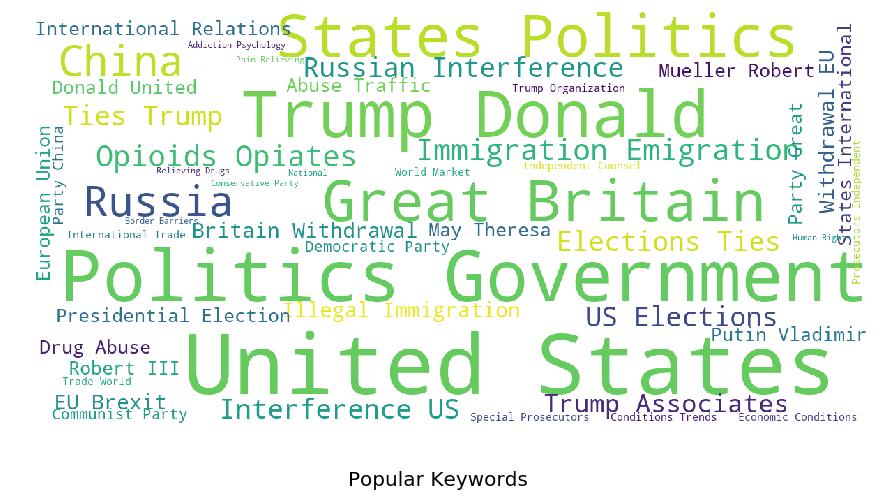

In [64]:
wordcloud_create(keywords_all, 'Popular Keywords')

The below lines were keywords analysis using rdd. The purpose is to practice word frequency calculation using rdd. It is a different representation of the wordcloud generated above.

In [21]:
keywords_rdd = sc.parallelize(keywords_all.split())

In [22]:
keywords_rdd.take(5)

['Forests', 'and', 'Forestry,', 'Siberia,', 'Russia,']

In [32]:
keywords_count = keywords_rdd.map(lambda x: x.strip(string.punctuation)).filter(lambda x: x != '').filter(lambda x: x not in STOPWORDS).map(lambda x: (x, 1)).reduceByKey(lambda a, b: a+b)

In [34]:
keywords_count.take(10)

[('Industry', 4),
 ('Wood', 2),
 ('Censorship', 7),
 ('Rap', 1),
 ('Shui', 1),
 ('Conditions', 25),
 ('Trends', 25),
 ('Trump', 303),
 ('J', 204),
 ('Corruption', 6)]

### Articles are matched with a given keyword. The below function looks if the keyword or article column contains the user specified keyword. The keyword column is evaluated first; if no match is found, the article column will be evaluated. Matches are returned in a dataframe reordered by word count in descending order.

In [14]:
def article_match(df, keyword):
    article_match = df[df['keywords'].str.contains(keyword) | df['article'].str.contains(keyword)].sort_values(by='word_count', ascending=False).reset_index(drop=True)
    article_match = article_match[article_match['article'] != ''] #remove entries with empty article body
    return article_match

### Use the article_df containing clean article body and selected metadata and the keyword "Mueller" as arguments to call the article_match() function.

In [15]:
article_match_mueller = article_match(article_df, 'Mueller')

Check the number of matched articles with keyword "Mueller"

In [19]:
len(article_match_mueller)

73

In [39]:
article_match_mueller.head() #matched articles are ordered by word count (descending)

,article,id,keywords,title,topic,word_count
0,Michael D. Cohen was at a breaking point. He t...,5cbc311d40d36ff0709d4277,"Cohen, Michael D (1966- ), Trump, Donald J, Co...",How Michael Cohen Turned Against President Trump,Trump,3509
1,WASHINGTON — The report on the investigation b...,5c954e4f40d36ff0709ca0e8,Russian Interference in 2016 US Elections and ...,"Russia, Trump and Mueller: The Major Moments i...",Russia,2144
2,WASHINGTON — Robert S. Mueller III revealed th...,5cb8c77c40d36ff0709d3d85,Russian Interference in 2016 US Elections and ...,Mueller Reveals Trump’s Efforts to Thwart Russ...,Russia,1976
3,WASHINGTON — President Trump delivered a messa...,5c8ae49340d36ff070804282,"Trump, Donald J, State of the Union Message (U...","Trump Asks for Unity, but Presses Hard Line on...",Immigration,1931
4,WASHINGTON — At 9:34 on the November morning a...,5cbb3aeb40d36ff0709d4171,Russian Interference in 2016 US Elections and ...,"Prodded by Putin, Russians Sought Back Channel...",Trump,1816


### Function article_common() takes the dataframe returned by article_match() as an argument, then computes the intersection of top two longest articles as similarity. Words with less than four letters are dropped. When creating the article rdds, punctuation, empty entries, and stopwords are removed. It returns the words that the two articles have in common as a string.

In [16]:
def article_common(df):
    article_1_rdd = sc.parallelize(df['article'][0].split()).map(lambda x: x.strip(string.punctuation)).filter(lambda x: x != '').filter(lambda x: x not in STOPWORDS)
    article_2_rdd = sc.parallelize(df['article'][1].split()).map(lambda x: x.strip(string.punctuation)).filter(lambda x: x != '').filter(lambda x: x not in STOPWORDS)
    article_common = article_1_rdd.filter(lambda x: len(x)>4).intersection(article_2_rdd.filter(lambda x: len(x)>4)).collect()
    article_common_all = ' '.join(article_common)
    return article_common_all

In [44]:
article_common_mueller = article_common(article_match_mueller)

In [45]:
print(article_common_mueller)

feared investigations continued unindicted money emails decision Thursday potential beyond seemed investigation really charge question mounting Russian investigating months charges longtime president’s federal prison campaign After whether might intended without among lying calling early simply election James court point adviser proposed possible private pulled tried aspects worked associates inquiry person States state Twitter publicly Comey around Mueller’s relating plead August criminal including counsel’s according guilty another complained sentence described denied agents asked director crime Michael Cohen President Trump effectively presidential White House happened declined reduce Mueller accused known added suspicions appearance agreement business official others details advisers lawyer relationship special payments events released Trump’s office initially company later discussed possibly information Russia words first truth involved agreed prosecutors Manhattan co-conspirator 

Visualize words in common using wordcloud

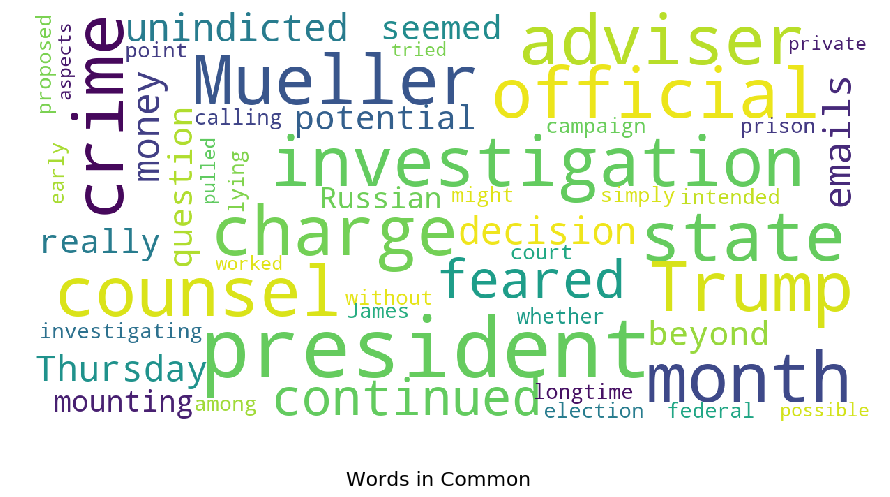

In [46]:
wordcloud_create(article_common_mueller, 'Words in Common')

### Try another keyword, "Opioid", to compute similarity.

In [69]:
article_match_opioid = article_match(article_df, "Opioid")

In [70]:
article_match_opioid.head()

,article,id,keywords,title,topic,word_count
0,"MARSHALLTOWN, Iowa — A newborn had arrived for...",5c88704740d36ff070b86911,"Iowa, Gastala, Nicole, Opioids and Opiates, Pa...",When an Iowa Family Doctor Takes On the Opioid...,Opioid,2644
1,"Purdue Pharma, the company that planted the se...",5c8ae32b40d36ff0707ff983,"Purdue Pharma, Sackler, Richard (1945- ), Opio...",Origins of an Epidemic: Purdue Pharma Knew Its...,Opioid,2558
2,"OAKLAND, Calif. — Every year, thousands of peo...",5c88abdb40d36ff070c40f28,"Highland Hospital (Oakland, Calif), Herring, A...",This E.R. Treats Opioid Addiction on Demand. T...,Opioid,2430
3,"The Sacklers had a new plan. It was 2014, and ...",5ca1b6fa40d36ff0709d0e98,"Opioids and Opiates, Sackler Family, Pain-Reli...",Lawsuits Lay Bare Sackler Family’s Role in Opi...,Opioid,2392
4,"There are the Sacklers, the family that contro...",5cbd8f0c40d36ff0709d43ec,"Opioids and Opiates, Drug Abuse and Traffic, D...",The Giants at the Heart of the Opioid Crisis,Opioid,2156


In [73]:
article_common_opioid = article_common(article_match_opioid)

In [74]:
print(article_common_opioid)

trying family epidemic treating Administration getting manager continued something months weeks addiction million among without federal earlier couple eager remains street agency’s learned articles Connecticut learn every simply early fentanyl public approved States needed prescription University worked three involving believed reminded safer whose always former heroin times drugs followed physician crushed including according mentioned moved another September addicts continue patients opioid painkillers Trump official Congress “This added already illegal meetings years community agency planned becoming older doctors people practice administration office abuse taken number required nothing meant later overdoses United doctor support medical consider meeting bring turned higher Vicodin problem small opioids health found enough study began prescribing Enforcement complex formulation Virginia taking Percocet report


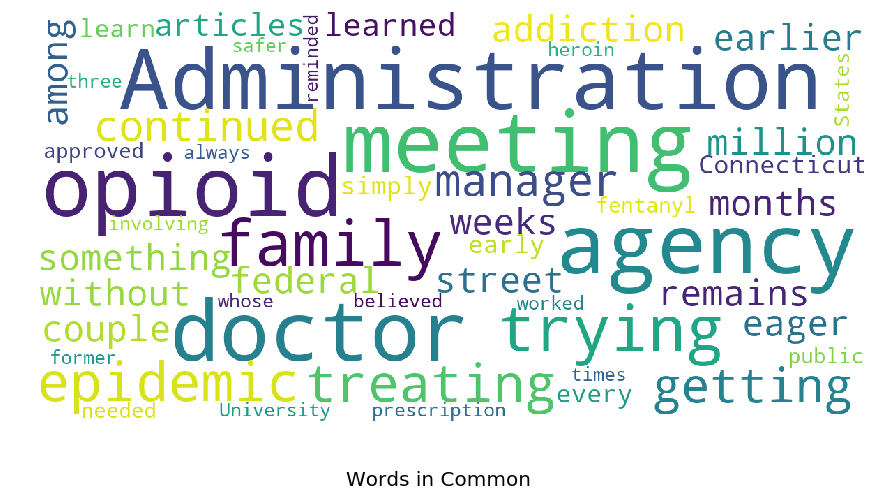

In [75]:
wordcloud_create(article_common_opioid, "Words in Common")

## Part 2.3: Compute similarity using spaCy

In [1]:
#pip install spacy
#python -m spacy download en_core_web_md
import spacy

### Spacy is a library for Natural Language Processing (NLP) in Python. The "en_core_web_md" model which contains 685k keys, 20k unique vectors (300 dimensions) is used here to compute text similarity. Spacy tokenizes, parses, and tags the text using the chosen statistical model. Similarity is computed by comparing word vectors (multi-dimensional meaning representations of a word).

In [19]:
nlp = spacy.load('en_core_web_md')

### Similarity computation using spacy and visualization using heatmap are wrapped in function article_common_spacy(). This functions takes the dataframe containing similar articles for a given keyword generated by function article_match() as an argument; the similarity scores are computed between pairs of the top three longest articles. The scores are converted into an array using numpy and visualized in the form of a heatmap. The x and y axes of the heatmap are labeled with article ids.

In [77]:
def article_common_spacy(df):
    #create npl objects from the top three longest articles
    doc1 = nlp(df['article'][0])
    doc2 = nlp(df['article'][1])
    doc3 = nlp(df['article'][2])
    #compute spacy similarity of each pairs
    doc1_1 = doc1.similarity(doc1)
    doc1_2 = doc1.similarity(doc2)
    doc1_3 = doc1.similarity(doc3)
    doc2_2 = doc2.similarity(doc2)
    doc2_3 = doc2.similarity(doc3)
    doc3_3 = doc3.similarity(doc3)
    #create numpy array of the similarity scores
    doc_array = np.array([[doc1_1, doc1_2, doc1_3], [doc1_2, doc2_2, doc2_3], [doc1_3, doc2_3, doc3_3]])
    #read article id to label x and y axes
    doc_id = [df['id'][0], df['id'][1], df['id'][2]]
    
    #create heatmap of similarity scores of the pairs
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(doc_array, cmap="seismic")

    #show all ticks
    ax.set_xticks(np.arange(len(doc_id)))
    ax.set_yticks(np.arange(len(doc_id)))
    #and label them with the respective article ids
    ax.set_xticklabels(doc_id, fontsize=12)
    ax.set_yticklabels(doc_id, fontsize=12)

    #rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #loop through data dimensions and create text annotations
    for i in range(len(doc_id)):
        for j in range(len(doc_id)):
            text = ax.text(j, i, doc_array[i, j], ha="center", va="center", color="w", fontsize=12)

    ax.set_title("Spacy Similarity of Three Longest Articles", fontsize=20)
    fig.tight_layout()
    plt.show()

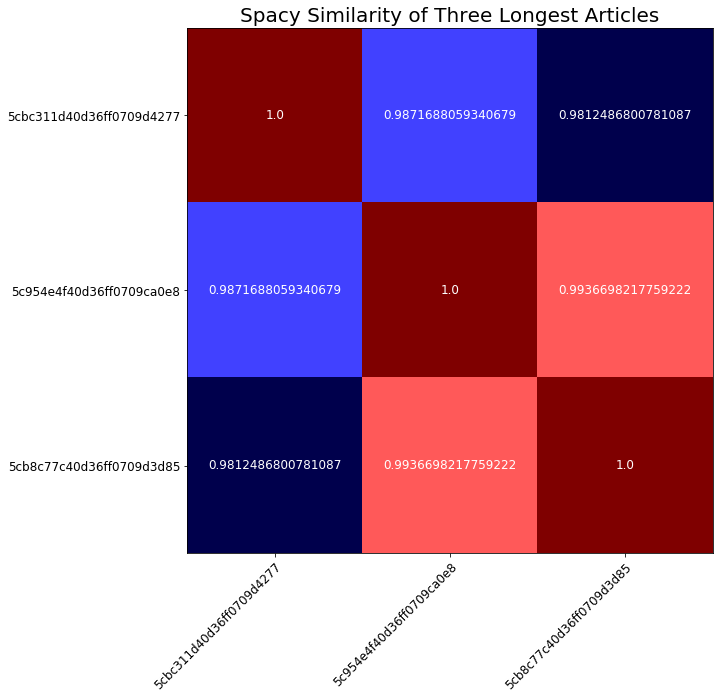

In [68]:
article_common_spacy(article_match_mueller)

### Try another keyword, "Opioid", and compute spacy similarity

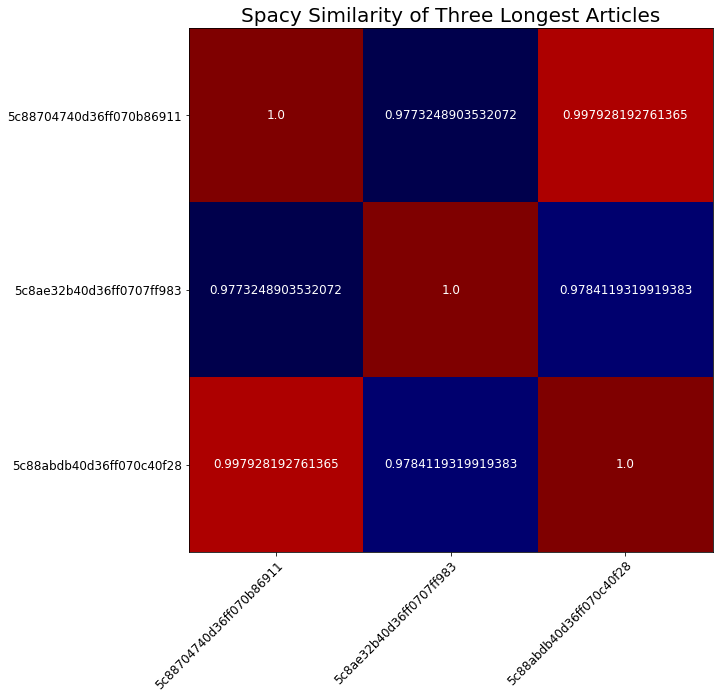

In [76]:
article_common_spacy(article_match_opioid)